In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
import spacy
from collections import Counter
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics.pairwise import cosine_similarity

ModuleNotFoundError: No module named 'nltk'

In [5]:
pip install nltk spacy 


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.0 MB/s eta 0:00:00
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [742 lines of output]
      Ignoring numpy: markers 'python_version < "3.9"' don't match your environment
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        Using cached murmurhash-1.0.11-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.0 kB)
        Installing build dependencies: started
        Installing build dependencies: still running...
        Installing build dependencies: finished with status 'done'
       

# Dataset
We firstly open the dataset created by us manually and with help of chatGPT to get the foods' description. If we use an AI to generate descriptions of food, then we just need to get new food names and get the descriptions easily. This will make the program scalable.

In [290]:
file_path = 'updated_food_data2-1.xlsx'
updated_food_data_df = pd.read_excel(file_path)
updated_food_data_df

,english_name,Characteristic,cuisine,category,English_ingredient,description,vegetarians,allergy
0,Gamjajeon,"Crispy, mild",Korean,fried,"Potatoes, water, salt, cooking oil",Gamjajeon is a type of pancake made primarily ...,1,NaN
1,Sundae Gukbap (Korean Blood Sausage Soup),earthy,Korean,"rice,soup","Commercial, green onion, cheongyang pepper, co...",Sundae Gukbap is a hearty Korean soup made wit...,1,NaN
2,Suyuk Gukbap (Boiled Pork Soup),earthy,Korean,"rice,soup","Pork belly, radish, bean sprouts, boiled sirae...",Suyuk Gukbap is a comforting Korean soup made ...,0,NaN
3,Pork Bone Hangover Soup,"spicy, nutty",Korean,"rice,soup","Pork spine, rugs, leeks, water","Pork Bone Hangover Soup, known as Gamjatang in...",0,NaN
4,Bean Sprout Soup,"crunchy, nutty, mild, clean",Korean,"rice,soup","Bean sprouts, leek, cheongyang pepper, shrimp,...","Bean Sprout Soup, known as Kongnamul-guk in Ko...",1,"shellfish, soy"
...,...,...,...,...,...,...,...,...
80,Salad,"Crunchy, mild, nutty, light",Korean,vegetables,"Plain yogurt, honey, lemon juice, mayonnaise, ...",Salad is a versatile dish made from a mix of f...,1,NaN
81,Sandwich,"Mild, nutty",Western,bread,"Bread, onion, cabbage, butter",A sandwich is a versatile dish consisting of f...,1,NaN
82,Hamburger,"Crispy, nutty, salty",Western,"bread,meat,vegetables","Pork, beef, onion, pickle, paprika, cheese, ha...",A hamburger is a popular dish consisting of a ...,0,NaN
83,Chicken Burger,"Crispy, nutty, salty, mild",Western,"bread,fried,vegetables","Morning bread, cabbage, chicken",A chicken burger is a flavorful sandwich made ...,0,NaN


# Text Preprocessing, Noun Extraction, and Entity Recognition for Keyword Extraction

1. **`preprocess_text` Function**: 
   - This function receives a raw text string as input.
   - It tokenizes the text, removing common stopwords and non-alphabetic tokens to filter out unimportant words.
   - Each token is then lemmatized (reduced to its base or "dictionary" form) using WordNetLemmatizer from NLTK. Lemmatization is crucial as it standardizes words, making variations of a word like "running" and "runs" equivalent to "run".
   - The resulting list of cleaned, meaningful words is returned as output.

2. **`get_nouns` Function**:
   - This function receives a list of tokens, typically after preprocessing.
   - It uses part-of-speech (POS) tagging to identify nouns, which are often central to determining the main subjects and concepts in the text.
   - Only words tagged as nouns (POS tags beginning with "NN") are kept, as they tend to represent entities or topics.
   - This filtered list of nouns is returned, narrowing down the tokens to those likely relevant for keywords.

3. **`get_entities` Function**:
   - This function performs named entity recognition (NER) on the original text using spaCy’s language model.
   - Named entities are proper nouns, locations, dates, and other significant phrases that provide context and specificity.
   - The function returns a list of these entities, capturing essential, named information in the text.

4. **`extract_keywords` Function**:
   - This function orchestrates the keyword extraction by combining the outputs from `preprocess_text`, `get_nouns`, and `get_entities`.
   - It first preprocesses the text, then extracts nouns from the processed tokens, and finally recognizes named entities in the original text.
   - The function merges the lists of nouns and entities, removing duplicates, to produce a final list of keywords that encompass both general topics and specific entities.


In [291]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    tokens = nltk.word_tokenize(text)

    lemmas = []
    for token in tokens:
        if token.lower() not in stop_words and token.isalpha():
            lemma = lemmatizer.lemmatize(token.lower())
            lemmas.append(lemma)
    return lemmas

def get_nouns(tokens):
    pos_tags = pos_tag(tokens)
    nouns = []
    for word, pos in pos_tags:
        if pos.startswith('NN'):
            nouns.append(word)
    return nouns


def get_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities


def extract_keywords(text):
    lemmas = preprocess_text(text)
    nouns = get_nouns(lemmas)
    entities = get_entities(text)
    relevant_keywords = list(set(nouns + entities))
    return relevant_keywords

In [292]:
updated_food_data_df['keywords'] = updated_food_data_df['description'].apply(

    lambda x: extract_keywords(str(x)) if isinstance(x, str) else extract_keywords("")

)
updated_food_data_df

,english_name,Characteristic,cuisine,category,English_ingredient,description,vegetarians,allergy,keywords
0,Gamjajeon,"Crispy, mild",Korean,fried,"Potatoes, water, salt, cooking oil",Gamjajeon is a type of pancake made primarily ...,1,NaN,"[gamjajeon, help, potato, flour, heat, create,..."
1,Sundae Gukbap (Korean Blood Sausage Soup),earthy,Korean,"rice,soup","Commercial, green onion, cheongyang pepper, co...",Sundae Gukbap is a hearty Korean soup made wit...,1,NaN,"[meal, Sundae Gukbap, create, piece, ingredien..."
2,Suyuk Gukbap (Boiled Pork Soup),earthy,Korean,"rice,soup","Pork belly, radish, bean sprouts, boiled sirae...",Suyuk Gukbap is a comforting Korean soup made ...,0,NaN,"[meal, juicy, ingredient, bone, broth, season,..."
3,Pork Bone Hangover Soup,"spicy, nutty",Korean,"rice,soup","Pork spine, rugs, leeks, water","Pork Bone Hangover Soup, known as Gamjatang in...",0,NaN,"[meal, spice, potato, Gamjatang, hour, create,..."
4,Bean Sprout Soup,"crunchy, nutty, mild, clean",Korean,"rice,soup","Bean sprouts, leek, cheongyang pepper, shrimp,...","Bean Sprout Soup, known as Kongnamul-guk in Ko...",1,"shellfish, soy","[sprout, Kongnamul, heat, bean, ingredient, br..."
...,...,...,...,...,...,...,...,...,...
80,Salad,"Crunchy, mild, nutty, light",Korean,vegetables,"Plain yogurt, honey, lemon juice, mayonnaise, ...",Salad is a versatile dish made from a mix of f...,1,NaN,"[fruit, meal, salad, ranch, caesar, crunch, se..."
81,Sandwich,"Mild, nutty",Western,bread,"Bread, onion, cabbage, butter",A sandwich is a versatile dish consisting of f...,1,NaN,"[meal, satisfying, bread, simple, snack, endle..."
82,Hamburger,"Crispy, nutty, salty",Western,"bread,meat,vegetables","Pork, beef, onion, pickle, paprika, cheese, ha...",A hamburger is a popular dish consisting of a ...,0,NaN,"[meal, bacon, patty, juicy, specialty, cheese,..."
83,Chicken Burger,"Crispy, nutty, salty, mild",Western,"bread,fried,vegetables","Morning bread, cabbage, chicken",A chicken burger is a flavorful sandwich made ...,0,NaN,"[mild, meal, bacon, patty, juicy, creaminess, ..."


In [293]:
def remove_duplicates(keywords):
    if isinstance(keywords, list):
        return list(set(keywords))
    return keywords  
updated_food_data_df['keywords'] = updated_food_data_df['keywords'].apply(remove_duplicates)

updated_food_data_df


,english_name,Characteristic,cuisine,category,English_ingredient,description,vegetarians,allergy,keywords
0,Gamjajeon,"Crispy, mild",Korean,fried,"Potatoes, water, salt, cooking oil",Gamjajeon is a type of pancake made primarily ...,1,NaN,"[gamjajeon, help, potato, flour, heat, create,..."
1,Sundae Gukbap (Korean Blood Sausage Soup),earthy,Korean,"rice,soup","Commercial, green onion, cheongyang pepper, co...",Sundae Gukbap is a hearty Korean soup made wit...,1,NaN,"[meal, Sundae Gukbap, create, piece, ingredien..."
2,Suyuk Gukbap (Boiled Pork Soup),earthy,Korean,"rice,soup","Pork belly, radish, bean sprouts, boiled sirae...",Suyuk Gukbap is a comforting Korean soup made ...,0,NaN,"[meal, juicy, ingredient, bone, broth, season,..."
3,Pork Bone Hangover Soup,"spicy, nutty",Korean,"rice,soup","Pork spine, rugs, leeks, water","Pork Bone Hangover Soup, known as Gamjatang in...",0,NaN,"[meal, spice, potato, Gamjatang, hour, create,..."
4,Bean Sprout Soup,"crunchy, nutty, mild, clean",Korean,"rice,soup","Bean sprouts, leek, cheongyang pepper, shrimp,...","Bean Sprout Soup, known as Kongnamul-guk in Ko...",1,"shellfish, soy","[sprout, Kongnamul, heat, bean, ingredient, br..."
...,...,...,...,...,...,...,...,...,...
80,Salad,"Crunchy, mild, nutty, light",Korean,vegetables,"Plain yogurt, honey, lemon juice, mayonnaise, ...",Salad is a versatile dish made from a mix of f...,1,NaN,"[fruit, meal, ranch, caesar, crunch, seed, ing..."
81,Sandwich,"Mild, nutty",Western,bread,"Bread, onion, cabbage, butter",A sandwich is a versatile dish consisting of f...,1,NaN,"[meal, satisfying, bread, snack, simple, endle..."
82,Hamburger,"Crispy, nutty, salty",Western,"bread,meat,vegetables","Pork, beef, onion, pickle, paprika, cheese, ha...",A hamburger is a popular dish consisting of a ...,0,NaN,"[meal, bacon, patty, juicy, specialty, cheese,..."
83,Chicken Burger,"Crispy, nutty, salty, mild",Western,"bread,fried,vegetables","Morning bread, cabbage, chicken",A chicken burger is a flavorful sandwich made ...,0,NaN,"[mild, meal, bacon, patty, juicy, creaminess, ..."


In [294]:
updated_food_data_df['keywords'] = updated_food_data_df['keywords'].apply(
    lambda keywords: [keyword for keyword in keywords if len(keyword) > 2]
)

updated_food_data_df

,english_name,Characteristic,cuisine,category,English_ingredient,description,vegetarians,allergy,keywords
0,Gamjajeon,"Crispy, mild",Korean,fried,"Potatoes, water, salt, cooking oil",Gamjajeon is a type of pancake made primarily ...,1,NaN,"[gamjajeon, help, potato, flour, heat, create,..."
1,Sundae Gukbap (Korean Blood Sausage Soup),earthy,Korean,"rice,soup","Commercial, green onion, cheongyang pepper, co...",Sundae Gukbap is a hearty Korean soup made wit...,1,NaN,"[meal, Sundae Gukbap, create, piece, ingredien..."
2,Suyuk Gukbap (Boiled Pork Soup),earthy,Korean,"rice,soup","Pork belly, radish, bean sprouts, boiled sirae...",Suyuk Gukbap is a comforting Korean soup made ...,0,NaN,"[meal, juicy, ingredient, bone, broth, season,..."
3,Pork Bone Hangover Soup,"spicy, nutty",Korean,"rice,soup","Pork spine, rugs, leeks, water","Pork Bone Hangover Soup, known as Gamjatang in...",0,NaN,"[meal, spice, potato, Gamjatang, hour, create,..."
4,Bean Sprout Soup,"crunchy, nutty, mild, clean",Korean,"rice,soup","Bean sprouts, leek, cheongyang pepper, shrimp,...","Bean Sprout Soup, known as Kongnamul-guk in Ko...",1,"shellfish, soy","[sprout, Kongnamul, heat, bean, ingredient, br..."
...,...,...,...,...,...,...,...,...,...
80,Salad,"Crunchy, mild, nutty, light",Korean,vegetables,"Plain yogurt, honey, lemon juice, mayonnaise, ...",Salad is a versatile dish made from a mix of f...,1,NaN,"[fruit, meal, ranch, caesar, crunch, seed, ing..."
81,Sandwich,"Mild, nutty",Western,bread,"Bread, onion, cabbage, butter",A sandwich is a versatile dish consisting of f...,1,NaN,"[meal, satisfying, bread, snack, simple, endle..."
82,Hamburger,"Crispy, nutty, salty",Western,"bread,meat,vegetables","Pork, beef, onion, pickle, paprika, cheese, ha...",A hamburger is a popular dish consisting of a ...,0,NaN,"[meal, bacon, patty, juicy, specialty, cheese,..."
83,Chicken Burger,"Crispy, nutty, salty, mild",Western,"bread,fried,vegetables","Morning bread, cabbage, chicken",A chicken burger is a flavorful sandwich made ...,0,NaN,"[mild, meal, bacon, patty, juicy, creaminess, ..."


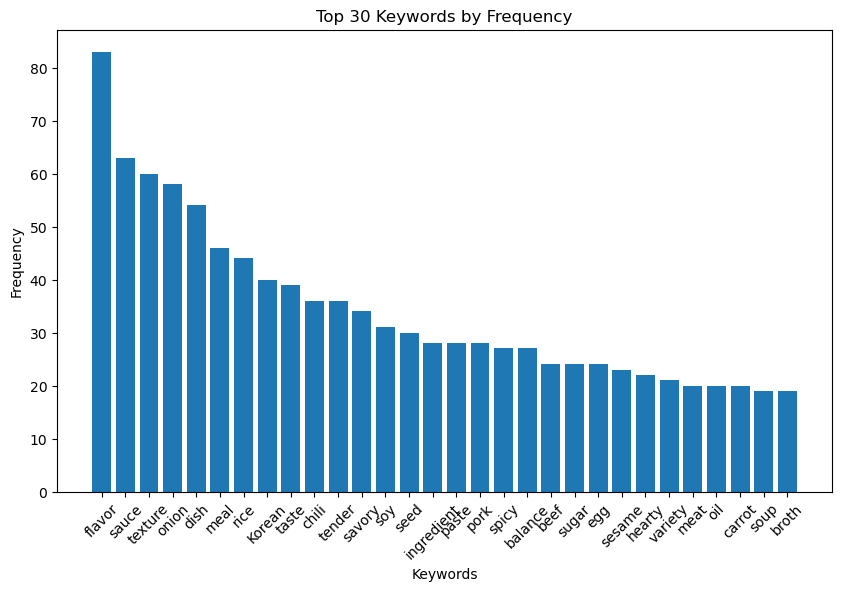

In [295]:
keywords_list = updated_food_data_df['keywords'].dropna().sum()
keywords_counts = Counter(keywords_list)

top_keywords_df = pd.DataFrame(keywords_counts.items(), columns=['Keyword', 'Count'])
top_keywords_df = top_keywords_df.sort_values(by='Count', ascending=False).head(30)

plt.figure(figsize=(10, 6))
plt.bar(top_keywords_df['Keyword'], top_keywords_df['Count'])
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Top 30 Keywords by Frequency')
plt.xticks(rotation=45)
plt.show()


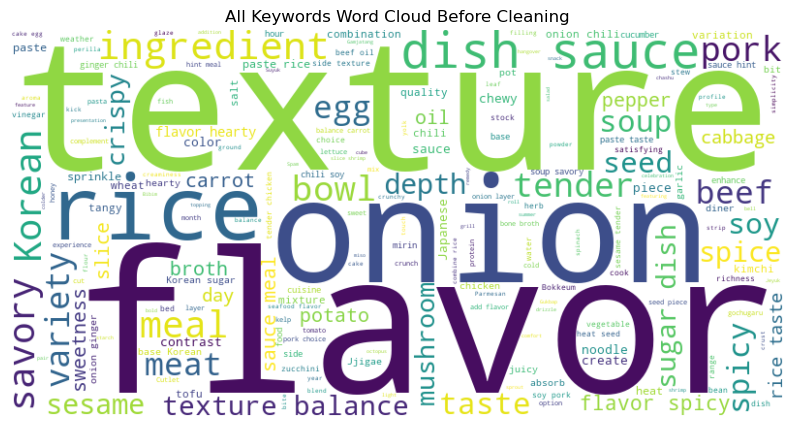

In [296]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords_list))

wordcloud.to_file("wordcloudB1.png")

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('All Keywords Word Cloud Before Cleaning')
plt.show()


In [297]:
keywords_counts

Counter({'flavor': 83,
         'sauce': 63,
         'texture': 60,
         'onion': 58,
         'dish': 54,
         'meal': 46,
         'rice': 44,
         'Korean': 40,
         'taste': 39,
         'chili': 36,
         'tender': 36,
         'savory': 34,
         'soy': 31,
         'seed': 30,
         'ingredient': 28,
         'pork': 28,
         'paste': 28,
         'spicy': 27,
         'balance': 27,
         'beef': 24,
         'egg': 24,
         'sugar': 24,
         'sesame': 23,
         'hearty': 22,
         'variety': 21,
         'carrot': 20,
         'oil': 20,
         'meat': 20,
         'broth': 19,
         'soup': 19,
         'heat': 18,
         'piece': 18,
         'slice': 17,
         'base': 17,
         'ginger': 17,
         'spice': 16,
         'depth': 16,
         'Japanese': 16,
         'crispy': 15,
         'side': 15,
         'mushroom': 15,
         'potato': 14,
         'sweetness': 14,
         'pepper': 14,
         'cabbage

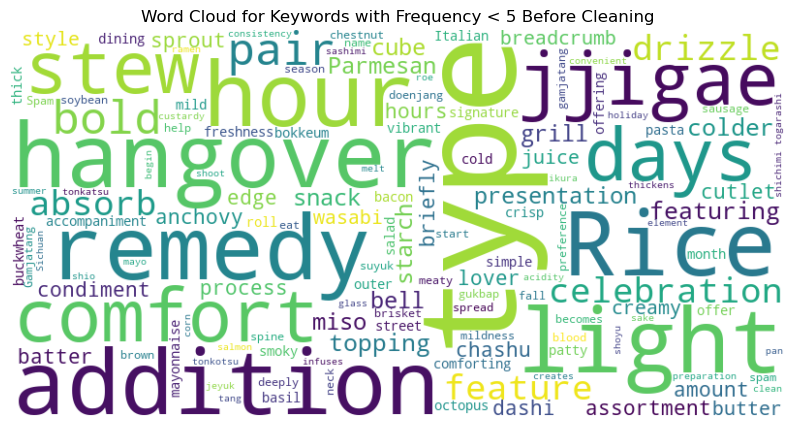

In [298]:
keywords_list = updated_food_data_df['keywords'].dropna().sum()
keywords_counts = Counter(keywords_list)

filtered_keywords_counts = {k: v for k, v in keywords_counts.items() if v < 5}

filtered_keywords_df = pd.DataFrame(filtered_keywords_counts.items(), columns=['Keyword', 'Count'])
filtered_keywords_df = filtered_keywords_df.sort_values(by='Count', ascending=False)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    relative_scaling=0.5, 
    min_font_size=10
).generate_from_frequencies(filtered_keywords_counts)
wordcloud.to_file("wordcloudB2.png")

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Keywords with Frequency < 5 Before Cleaning')
plt.show()


## Cleaning

In [299]:
# keywords = list(keywords_counts.keys())

# with open('keywords2.txt', 'w') as file:
#     for keyword in keywords:
#         file.write(f"{keyword}\n")

In [300]:
non_food_keywords_path = "non_food_keywords.txt"
with open(non_food_keywords_path, "r") as file:
    non_food_keywords = set(file.read().splitlines())

updated_food_data_df["keywords"] = updated_food_data_df["keywords"].apply(
    lambda keywords: [word for word in keywords if word not in non_food_keywords]
)



In [301]:
non_food_keywords_path = "unrelated_words.txt"
with open(non_food_keywords_path, "r") as file:
    non_food_keywords = set(file.read().splitlines())

updated_food_data_df["keywords"] = updated_food_data_df["keywords"].apply(
    lambda keywords: [word for word in keywords if word not in non_food_keywords]
)



In [302]:
updated_food_data_df

,english_name,Characteristic,cuisine,category,English_ingredient,description,vegetarians,allergy,keywords
0,Gamjajeon,"Crispy, mild",Korean,fried,"Potatoes, water, salt, cooking oil",Gamjajeon is a type of pancake made primarily ...,1,NaN,"[gamjajeon, potato, flour, vinegar, pancake, s..."
1,Sundae Gukbap (Korean Blood Sausage Soup),earthy,Korean,"rice,soup","Commercial, green onion, cheongyang pepper, co...",Sundae Gukbap is a hearty Korean soup made wit...,1,NaN,"[Sundae Gukbap, bone, broth, blood, stomach, s..."
2,Suyuk Gukbap (Boiled Pork Soup),earthy,Korean,"rice,soup","Pork belly, radish, bean sprouts, boiled sirae...",Suyuk Gukbap is a comforting Korean soup made ...,0,NaN,"[bone, broth, soup, gukbap, diner, shrimp, ten..."
3,Pork Bone Hangover Soup,"spicy, nutty",Korean,"rice,soup","Pork spine, rugs, leeks, water","Pork Bone Hangover Soup, known as Gamjatang in...",0,NaN,"[spice, potato, Gamjatang, seed, bone, broth, ..."
4,Bean Sprout Soup,"crunchy, nutty, mild, clean",Korean,"rice,soup","Bean sprouts, leek, cheongyang pepper, shrimp,...","Bean Sprout Soup, known as Kongnamul-guk in Ko...",1,"shellfish, soy","[sprout, Kongnamul, bean, broth, soup, kelp, B..."
...,...,...,...,...,...,...,...,...,...
80,Salad,"Crunchy, mild, nutty, light",Korean,vegetables,"Plain yogurt, honey, lemon juice, mayonnaise, ...",Salad is a versatile dish made from a mix of f...,1,NaN,"[fruit, ranch, caesar, seed, mix, Caesar, tuna..."
81,Sandwich,"Mild, nutty",Western,bread,"Bread, onion, cabbage, butter",A sandwich is a versatile dish consisting of f...,1,NaN,"[bread, snack, simple, endless, tomato, ham, s..."
82,Hamburger,"Crispy, nutty, salty",Western,"bread,meat,vegetables","Pork, beef, onion, pickle, paprika, cheese, ha...",A hamburger is a popular dish consisting of a ...,0,NaN,"[bacon, patty, specialty, cheese, mushroom, Cl..."
83,Chicken Burger,"Crispy, nutty, salty, mild",Western,"bread,fried,vegetables","Morning bread, cabbage, chicken",A chicken burger is a flavorful sandwich made ...,0,NaN,"[mild, bacon, patty, creaminess, sandwich, bre..."


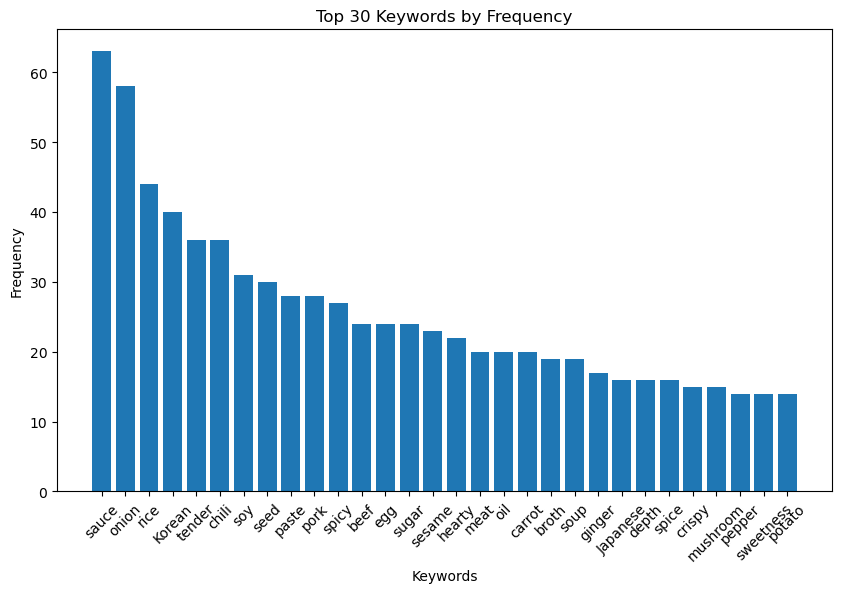

In [303]:
keywords_list = updated_food_data_df['keywords'].dropna().sum()
keywords_counts = Counter(keywords_list)

top_keywords_df = pd.DataFrame(keywords_counts.items(), columns=['Keyword', 'Count'])
top_keywords_df = top_keywords_df.sort_values(by='Count', ascending=False).head(30)

plt.figure(figsize=(10, 6))
plt.bar(top_keywords_df['Keyword'], top_keywords_df['Count'])
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Top 30 Keywords by Frequency')
plt.xticks(rotation=45)
plt.show()


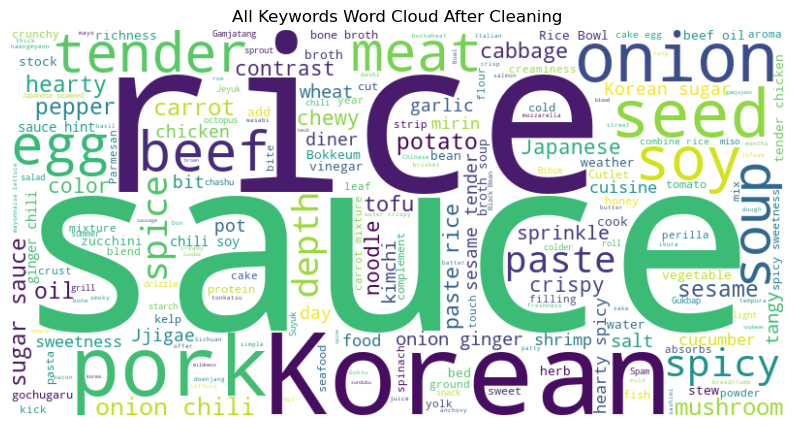

In [304]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords_list))

wordcloud.to_file("wordcloudCl1.png")

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('All Keywords Word Cloud After Cleaning')
plt.show()


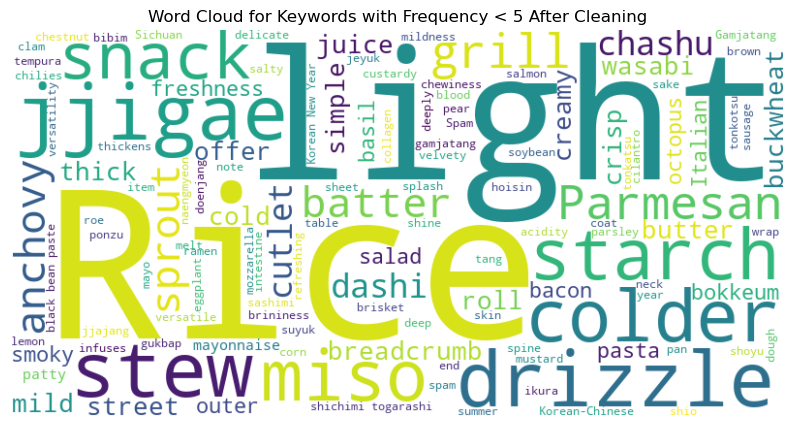

In [305]:
keywords_list = updated_food_data_df['keywords'].dropna().sum()
keywords_counts = Counter(keywords_list)

filtered_keywords_counts = {k: v for k, v in keywords_counts.items() if v < 5}

filtered_keywords_df = pd.DataFrame(filtered_keywords_counts.items(), columns=['Keyword', 'Count'])
filtered_keywords_df = filtered_keywords_df.sort_values(by='Count', ascending=False)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    relative_scaling=0.5, 
    min_font_size=10
).generate_from_frequencies(filtered_keywords_counts)

wordcloud.to_file("wordcloudCl2.png")

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Keywords with Frequency < 5 After Cleaning')
plt.show()


# Analyzing Chat GPT's text
We asked chat GPT to write some messages the user's could tell us on the app and also to tell us the positive and negative keywords of the message. Using that we can measure how well our application is working on finding keywords and also analyzing the sentiment of them.

In [306]:
messages = []
positive_keywords = []
negative_keywords = []
mapping_file_path_extended = 'food_message_keywords_mapping_extended.txt'

with open(mapping_file_path_extended, 'r') as file:
    for line in file:
        if line.startswith("Message:"):
            messages.append(line[len("Message: "):].strip())
        elif line.startswith("Positive Keywords:"):
            positive_keywords.append(line[len("Positive Keywords: "):].strip().split(", "))
        elif line.startswith("Negative Keywords:"):
            negative_keywords.append(line[len("Negative Keywords: "):].strip().split(", "))

df_trial = pd.DataFrame({
    "message": messages,
    "positive_keywords": positive_keywords,
    "negative_keywords": negative_keywords
})


In [307]:
df_trial

,message,positive_keywords,negative_keywords
0,I feel like eating something spicy tonight.,[spicy],[None]
1,I’m craving something sweet but not too heavy.,[sweet],[None]
2,Can you suggest a meal with lots of veggies?,[veggies],[None]
3,I’d love to have something quick and easy to eat.,[quick],[None]
4,I want something rich and savory.,[savory],[None]
5,"I don’t want anything fried, maybe something g...",[grilled],[fried]
6,"No dairy, please; my stomach can’t handle it r...",[None],[dairy]
7,I’m in the mood for seafood.,[seafood],[None]
8,How about a comforting soup?,[soup],[None]
9,I’d prefer something gluten-free.,[gluten-free],[None]


In [308]:
df_trial['keywords'] = df_trial['message'].apply(

    lambda x: extract_keywords(str(x)) if isinstance(x, str) else extract_keywords("")

)
df_trial['keywords'] = df_trial['keywords'].apply(remove_duplicates)
df_trial

,message,positive_keywords,negative_keywords,keywords
0,I feel like eating something spicy tonight.,[spicy],[None],"[something, spicy, tonight, feel]"
1,I’m craving something sweet but not too heavy.,[sweet],[None],[something]
2,Can you suggest a meal with lots of veggies?,[veggies],[None],"[meal, lot, veggie]"
3,I’d love to have something quick and easy to eat.,[quick],[None],"[something, eat]"
4,I want something rich and savory.,[savory],[None],"[something, savory]"
5,"I don’t want anything fried, maybe something g...",[grilled],[fried],"[something, want, anything]"
6,"No dairy, please; my stomach can’t handle it r...",[None],[dairy],"[right, dairy, stomach, handle, please]"
7,I’m in the mood for seafood.,[seafood],[None],"[mood, seafood]"
8,How about a comforting soup?,[soup],[None],[soup]
9,I’d prefer something gluten-free.,[gluten-free],[None],"[something, prefer]"


In [309]:
df_trial['positive_keywords'] = df_trial['positive_keywords'].apply(lambda x: [kw for kw in x if kw != "None"])
df_trial['negative_keywords'] = df_trial['negative_keywords'].apply(lambda x: [kw for kw in x if kw != "None"])

df_trial

,message,positive_keywords,negative_keywords,keywords
0,I feel like eating something spicy tonight.,[spicy],[],"[something, spicy, tonight, feel]"
1,I’m craving something sweet but not too heavy.,[sweet],[],[something]
2,Can you suggest a meal with lots of veggies?,[veggies],[],"[meal, lot, veggie]"
3,I’d love to have something quick and easy to eat.,[quick],[],"[something, eat]"
4,I want something rich and savory.,[savory],[],"[something, savory]"
5,"I don’t want anything fried, maybe something g...",[grilled],[fried],"[something, want, anything]"
6,"No dairy, please; my stomach can’t handle it r...",[],[dairy],"[right, dairy, stomach, handle, please]"
7,I’m in the mood for seafood.,[seafood],[],"[mood, seafood]"
8,How about a comforting soup?,[soup],[],[soup]
9,I’d prefer something gluten-free.,[gluten-free],[],"[something, prefer]"


In [310]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_match_percentage(row, columnName, threshold=0.7):
    positive_embeddings = model.encode(row['positive_keywords'], convert_to_tensor=True) if row['positive_keywords'] else None
    negative_embeddings = model.encode(row['negative_keywords'], convert_to_tensor=True) if row['negative_keywords'] else None
    keywords_embeddings = model.encode(row[columnName], convert_to_tensor=True) if row[columnName] else None

    positive_matches = 0
    negative_matches = 0
    
    if positive_embeddings is not None and keywords_embeddings is not None:
        for positive in positive_embeddings:
            for keyword_embedding in keywords_embeddings:
                similarity = cosine_similarity(positive.unsqueeze(0), keyword_embedding.unsqueeze(0))
                if similarity >= threshold:
                    positive_matches += 1  

    if negative_embeddings is not None and keywords_embeddings is not None:
        for negative in negative_embeddings:
            for keyword_embedding in keywords_embeddings:
                similarity = cosine_similarity(negative.unsqueeze(0), keyword_embedding.unsqueeze(0))
                if similarity >= threshold:
                    negative_matches += 1  

    total_keywords = len(row['positive_keywords']) + len(row['negative_keywords'])
    matched_keywords = positive_matches + negative_matches
    
    return (matched_keywords / total_keywords) * 100 if total_keywords > 0 else 0

df_trial['match_percentage'] = df_trial.apply(calculate_match_percentage, axis=1, columnName='keywords')
df_trial


,message,positive_keywords,negative_keywords,keywords,match_percentage
0,I feel like eating something spicy tonight.,[spicy],[],"[something, spicy, tonight, feel]",100.000000
1,I’m craving something sweet but not too heavy.,[sweet],[],[something],0.000000
2,Can you suggest a meal with lots of veggies?,[veggies],[],"[meal, lot, veggie]",100.000000
3,I’d love to have something quick and easy to eat.,[quick],[],"[something, eat]",0.000000
4,I want something rich and savory.,[savory],[],"[something, savory]",100.000000
5,"I don’t want anything fried, maybe something g...",[grilled],[fried],"[something, want, anything]",0.000000
6,"No dairy, please; my stomach can’t handle it r...",[],[dairy],"[right, dairy, stomach, handle, please]",100.000000
7,I’m in the mood for seafood.,[seafood],[],"[mood, seafood]",100.000000
8,How about a comforting soup?,[soup],[],[soup],100.000000
9,I’d prefer something gluten-free.,[gluten-free],[],"[something, prefer]",0.000000


In [311]:
total_match_percentage = df_trial['match_percentage'].mean()
total_match_percentage


52.962962962962955

In [312]:
keywords_set = {keyword for sublist in updated_food_data_df['keywords'] for keyword in sublist}

df_trial['new_keywords'] = df_trial['message'].apply(

    lambda message: [keyword for keyword in keywords_set if keyword in message]

)

In [313]:
df_trial['match_percentage2'] = df_trial.apply(calculate_match_percentage, axis=1, columnName='new_keywords')

In [314]:
total_match_percentage = df_trial['match_percentage2'].mean()
total_match_percentage


56.666666666666664

In [315]:
df_trial['combined_keywords'] = df_trial.apply(
    lambda row: list(set(row['keywords'] + row['new_keywords'])), axis=1
)

In [316]:
df_trial['match_percentage3'] = df_trial.apply(calculate_match_percentage, axis=1, columnName='combined_keywords')

In [317]:
total_match_percentage = df_trial['match_percentage3'].mean()
total_match_percentage

70.0

# Aspect-Based Sentiment Analysis (ABSA) Using DeBERTa Model

We use the `transformers` library to load and apply the model `yangheng/deberta-v3-large-absa-v1.1` for ABSA. The steps are as follows:

1. **Loading the Model**:
   - We start by loading the DeBERTa model and tokenizer from Hugging Face's Transformers library.

2. **Aspect-Based Sentiment Analysis Function**:
   - The main function, `aspect_based_sentiment_analysis`, takes a text input and a list of aspects to evaluate.
   - For each aspect, the function:
     - Concatenates the aspect with the text using a separator (`[SEP]`), following the format needed for ABSA.
     - Tokenizes this combined input and passes it through the model.
     - Obtains the model's output, interprets the logits, and maps the predicted class ID to a sentiment label (negative, neutral, or positive).
   - It returns a dictionary where each aspect is mapped to its predicted sentiment.


In [318]:
model_name = 'yangheng/deberta-v3-large-absa-v1.1'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def aspect_based_sentiment_analysis(text, aspects):
    sentiment_results = {}

    for aspect in aspects:
        aspect_text = f"{text} [SEP] {aspect}"
        inputs = tokenizer(aspect_text, return_tensors='pt', truncation=True)
        outputs = model(**inputs)
        logits = outputs.logits

        negative_logit = logits[0][0].item()
        positive_logit = logits[0][2].item()

        if positive_logit > negative_logit:
            sentiment = "positive"
        else:
            sentiment = "negative"

        sentiment_results[aspect] = sentiment

    return sentiment_results


/home/gogenola/anaconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [319]:
df_trial['sentiment_analysis'] = df_trial.apply(lambda row: aspect_based_sentiment_analysis(row['message'], row['combined_keywords']), axis=1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [320]:
df_trial.iloc[14]['sentiment_analysis']

{'ice': 'positive', 'spice': 'positive', 'something': 'positive'}

In [321]:
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

def calculate_accuracy_with_similarity(row, threshold=0.7):
    sentiment_results = row['sentiment_analysis']
    positive_keywords = row['positive_keywords']
    negative_keywords = row['negative_keywords']
    positive_embeddings = model.encode(positive_keywords, convert_to_tensor=True) if positive_keywords else []
    negative_embeddings = model.encode(negative_keywords, convert_to_tensor=True) if negative_keywords else []
    
    correct_predictions = 0
    total_counted = 0

    for keyword, predicted_sentiment in sentiment_results.items():
        keyword_embedding = model.encode([keyword], convert_to_tensor=True)
        max_positive_similarity = max([cosine_similarity(keyword_embedding, pos_emb.unsqueeze(0)).item() for pos_emb in positive_embeddings], default=0)
        max_negative_similarity = max([cosine_similarity(keyword_embedding, neg_emb.unsqueeze(0)).item() for neg_emb in negative_embeddings], default=0)

        if max_positive_similarity >= threshold:
            true_sentiment = "positive"
        elif max_negative_similarity >= threshold:
            true_sentiment = "negative"
        else:
            continue  

        if predicted_sentiment == true_sentiment:
            correct_predictions += 1
        total_counted += 1
    return (correct_predictions / total_counted) * 100 if total_counted > 0 else None

df_trial['accuracy_percentage'] = df_trial.apply(calculate_accuracy_with_similarity, axis=1)

df_trial[['message', 'positive_keywords', 'negative_keywords', 'sentiment_analysis', 'accuracy_percentage']]


,message,positive_keywords,negative_keywords,sentiment_analysis,accuracy_percentage
0,I feel like eating something spicy tonight.,[spicy],[],"{'icy': 'positive', 'tonight': 'positive', 'sp...",100.000000
1,I’m craving something sweet but not too heavy.,[sweet],[],"{'sweet': 'positive', 'something': 'positive'}",100.000000
2,Can you suggest a meal with lots of veggies?,[veggies],[],"{'meal': 'positive', 'lot': 'positive', 'egg':...",100.000000
3,I’d love to have something quick and easy to eat.,[quick],[],"{'something': 'positive', 'eat': 'positive'}",NaN
4,I want something rich and savory.,[savory],[],"{'something': 'positive', 'savory': 'positive'}",100.000000
5,"I don’t want anything fried, maybe something g...",[grilled],[fried],"{'something': 'positive', 'want': 'positive', ...",100.000000
6,"No dairy, please; my stomach can’t handle it r...",[],[dairy],"{'right': 'negative', 'dairy': 'negative', 'ea...",100.000000
7,I’m in the mood for seafood.,[seafood],[],"{'sea': 'positive', 'mood': 'positive', 'seafo...",100.000000
8,How about a comforting soup?,[soup],[],{'soup': 'positive'},100.000000
9,I’d prefer something gluten-free.,[gluten-free],[],"{'something': 'positive', 'prefer': 'positive'}",NaN


In [322]:
average_accuracy = df_trial['accuracy_percentage'].mean(skipna=True)
average_accuracy

98.09523809523809

# How to work

In [323]:
keywords_set = set()

for sublist in updated_food_data_df['keywords']:
    for keyword in sublist:
        keywords_set.add(keyword)

def process_and_combine_keywords(message, keywords_set):
    message = str(message) if isinstance(message, str) else "" 
    extracted_keywords = extract_keywords(message)  
    extracted_keywords = remove_duplicates(extracted_keywords)  
    new_keywords = []
    for keyword in keywords_set: 
        if keyword.lower() in message.lower():
            new_keywords.append(keyword)
    combined_keywords = []
    for keyword in extracted_keywords + new_keywords:
        if keyword not in combined_keywords:
            combined_keywords.append(keyword)
    
    return combined_keywords

message = "Some pizza would be fine"
result = process_and_combine_keywords(message, keywords_set)
print(result)

['pizza']


In [324]:
message = "Some pizza would not be fine"
keywords = process_and_combine_keywords(message, keywords_set)
print(keywords)
model_name = 'yangheng/deberta-v3-large-absa-v1.1'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_results = aspect_based_sentiment_analysis(message, keywords)
print(sentiment_results)


['pizza']


/home/gogenola/anaconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'pizza': 'negative'}
